In [1]:
import os
from distutils.dir_util import copy_tree
import itertools
import scipy
from scipy import stats
import dask.dataframe as dd
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time, pytz
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter

In [2]:
store_location = "./SurfCoefficients50days/"

combination_tuples_pearson = dict()
combination_tuples_spearman = dict()
combination_tuples_kendall = dict()

In [3]:
folders = next(os.walk(store_location))[1]

for folder in folders:
    start_date = folder.split("_")[0]
    
    for combination_file in next(os.walk(os.path.join(store_location, folder)))[2]:
        with open(os.path.join(store_location, folder, combination_file)) as coef_file:
            pc, sc, kc = coef_file.readline().split("|")
            pv_pc, pv_sc, pv_kc = coef_file.readline().split("|")
#             print(pc, sc, kc)
#             print(pv_pc, pv_sc, pv_kc)
            combination_tuples_pearson.setdefault(combination_file, []).append((pc, start_date, pv_pc))
            combination_tuples_spearman.setdefault(combination_file, []).append((sc, start_date, pv_sc))
            combination_tuples_kendall.setdefault(combination_file, []).append((kc, start_date, pv_kc))

In [209]:
threshold = 0.9

for combination, values in combination_tuples_spearman.items():
    num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
    if num_values_above_threshold == len(next(os.walk(store_location))[1]):
        print(combination)

node_memory_Slab+node_memory_SReclaimable_correlations.csv
node_network_receive_packets+node_netstat_Ip_OutRequests_correlations.csv
node_network_receive_packets+node_netstat_Tcp_InSegs_correlations.csv
node_network_receive_packets+node_netstat_Tcp_OutSegs_correlations.csv
node_network_receive_packets+node_netstat_Ip_InReceives_correlations.csv
node_network_receive_packets+node_network_transmit_packets_correlations.csv
node_network_receive_packets+node_netstat_Ip_InDelivers_correlations.csv
node_netstat_Ip_OutRequests+node_netstat_Tcp_InSegs_correlations.csv
node_netstat_Ip_OutRequests+node_netstat_TcpExt_TCPHPAcks_correlations.csv
node_netstat_Ip_OutRequests+node_netstat_Tcp_OutSegs_correlations.csv
node_netstat_Ip_OutRequests+node_netstat_Ip_InReceives_correlations.csv
node_netstat_Ip_OutRequests+node_network_transmit_packets_correlations.csv
node_netstat_Ip_OutRequests+node_netstat_Ip_InDelivers_correlations.csv
node_memory_MemTotal+node_memory_CommitLimit_correlations.csv
node_nets

In [204]:
threshold = 0.7

for combination, values in combination_tuples_pearson.items():
#     print(abs(float('nan')) >= threshold)
#     break
#     print(combination)
    num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
#     print(num_values_above_threshold)
#     break
    if num_values_above_threshold == len(next(os.walk(store_location))[1]):
        print(combination)


node_netstat_TcpExt_TCPFastRetrans+node_netstat_TcpExt_TCPAutoCorking_correlations.csv 50
node_memory_Slab+node_memory_Active_file_correlations.csv 50
nvidia_gpu_fanspeed_percent+node_memory_MemFree_correlations.csv 50
node_memory_Buffers+node_sockstat_sockets_used_correlations.csv 50


In [5]:
# Execute this cell to generate the plots
tuple_list = [val for i in combination_tuples_spearman.keys() for val in combination_tuples_spearman[i]]
df = pd.DataFrame(tuple_list, columns=['coef', 'start_date', 'pval'])
df = df.replace("nan", np.nan).dropna().reset_index(drop=True)
df['start_date'] = pd.to_datetime(df['start_date'], unit='s')
df['coef'] = df['coef'].astype(np.float)

df

,coef,start_date,pval
0,-0.050349,2019-12-29 23:00:00,0.0
1,-0.056175,2019-12-30 23:00:00,0.0
2,-0.026820,2019-12-31 23:00:00,6.969281239135855e-286
3,0.210491,2020-01-01 23:00:00,0.0
4,0.722381,2020-01-02 23:00:00,0.0
...,...,...,...
362233,0.477860,2020-02-17 23:00:00,0.0
362234,0.485456,2020-02-18 23:00:00,0.0
362235,0.217718,2020-02-11 23:00:00,0.0
362236,0.270654,2020-02-17 23:00:00,0.0


In [211]:
df.iloc[df[df['coef'].abs() >= 0.5]['pval'].astype(np.double).idxmax()]


coef                     0.722381
start_date    2020-01-02 23:00:00
pval                          0.0
Name: 4, dtype: object

In [202]:
count_df = df[df['coef'].abs() >= .7].groupby('start_date').count()
count_df

,coef,pval
start_date,,
2019-12-29 23:00:00,260,260
2019-12-30 23:00:00,258,258
2019-12-31 23:00:00,264,264
2020-01-01 23:00:00,298,298
2020-01-02 23:00:00,1980,1980
2020-01-03 23:00:00,1730,1730
2020-01-04 23:00:00,756,756
2020-01-05 23:00:00,508,508
2020-01-06 23:00:00,438,438


P-value range: [0.0, 0.0]


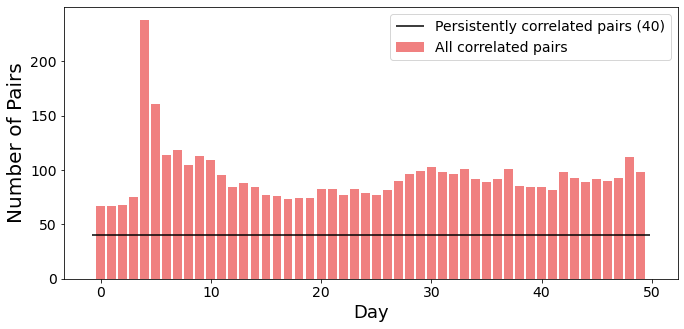

In [6]:
fig, ax = plt.subplots(figsize=(11, 5))
# ax.invert_xaxis()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel("Day", fontsize=18)
# ax.set_ylabel("Correlations $\geq$ threshold", fontsize=20)
ax.set_ylabel("Number of Pairs", fontsize=20)
# ax.xaxis_date()

# These two must match in size for the zip() function later
thresholds = [0.9,
#               0.7,
#               0.5,
             ]
colors = ["lightcoral", "steelblue", "yellowgreen"]
linestyles = ['solid', 'dashed', 'dotted']

for threshold in thresholds:
    print(f"P-value range: [{df[df['coef'].abs() >= threshold]['pval'].min()}, {df[df['coef'].abs() >= threshold]['pval'].max()}]")

bottom = None
for threshold, color, linestyle in zip(thresholds, colors, linestyles):
    count_df = df[df['coef'].abs() >= threshold].groupby('start_date').count().rename(columns={'coef': 'count'})
    data = count_df.copy()
    if bottom is not None:
        data['count'] -= bottom['count']  # As we expect more matches for a lower threshold, subtract the previous one to get the correct stack
    
    ax.bar(x=range(len(data)), height=data['count'], bottom=bottom['count'] if bottom is not None else 0, label="All correlated pairs", color=color)
    bottom = count_df
    
    num_coef_corr_all_days = 0
    for combination, values in combination_tuples_spearman.items():
        num_values_above_threshold = sum([1 if abs(float(v[0])) >= threshold else 0 for v in values])
        if num_values_above_threshold == len(next(os.walk(store_location))[1]):
            num_coef_corr_all_days += 1
    
    ax.hlines(num_coef_corr_all_days, xmin=-.8, xmax=len(data) - .2, color="black", linestyle=linestyle, label=f"Persistently correlated pairs ({num_coef_corr_all_days})")

def get_converted_xticks(ax):
    """
    :param ax:
    :return list of day and month strings
    """
    # return [pd.to_datetime(start + tick, unit='s').date().strftime("%d\n%b") for tick in ax.get_xticks()]
    return [int((tick) / 3600) for tick in ax.get_xticks()]  # Get the hour number

# unique_dates = sorted(df['start_date'].unique())
# ax.set_xticks([unique_dates[i] for i in np.linspace(0, len(unique_dates)-1, num=6, dtype=int)])  # Make sure we include 0 and the last value in the plot, so set the xticks ourselves
ax.legend(prop={"size": 14})

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"spearman_correlations_50_days_{date_time}.pdf", bbox_inches = "tight")
# fig.savefig(f"spearman_correlations_50_days_{date_time}.png", bbox_inches = "tight")